# Probabilistic methods

First install and import needed packages and libraries

In [1]:
# !pip install numpy scipy pandas matplotlib scikit-learn pyarrow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Spam Detection

We're going to use a Naive Bayes classifier for binary classification of emails. We'll perform a "spam/ham classification"

The data we're going to use was described in an article : 
> Metsis, Vangelis, Ion Androutsopoulos, and Georgios Paliouras. *"Spam filtering with Naive Bayes - which Naive Bayes?."* CEAS. Vol. 17. 2006. [link](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf)

It uses the [Enron Spam dataset](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html) as a source of emails that are not considered as spam.

Spam emails were obtained from 4 different sources:
1. [SpamAssassin dataset](https://spamassassin.apache.org/old/publiccorpus/)
2. [Project Honeypot](https://www.projecthoneypot.org/)
3. [Bruce Guenter's spam database](http://untroubled.org/spam/)
4. Emails collected by one of the authors of the article - Georgiosa Paliourasa.

We're going to use a processed version of this dataset that can be obtained using script in this [repository](https://github.com/MWiechmann/enron_spam_data?fbclid=IwAR1icPxic8TDD6HGk6empohwcZ76uig0NxwxK7sWbczinBNfxEEt-ETparA).

In [3]:
df = pd.read_csv("enron_spam_data.csv")
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


We don't need the `Message ID` and `Date` columns

In [4]:
df[["Subject", "Message"]] = df[["Subject", "Message"]].fillna("")
df["text"] = df["Subject"].str.cat(df["Message"])
df = df[
    [
        "text",
        "Spam/Ham",
    ]
]

df["Spam/Ham"] = (df["Spam/Ham"] == "spam").astype(int)

y = df.pop("Spam/Ham")
texts = df["text"]

[Text(0, 0, '50.93'), Text(0, 0, '49.07')]

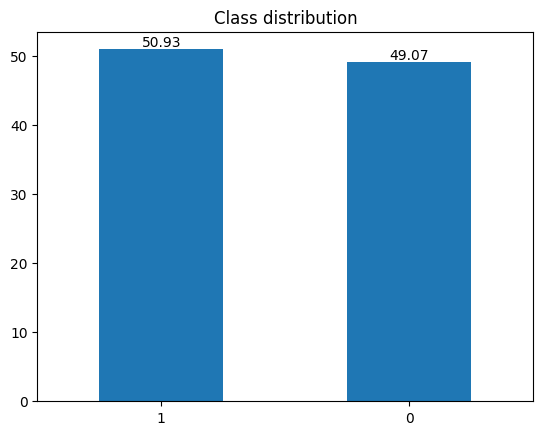

In [5]:
class_percentages = y.value_counts(normalize=True)
class_percentages = round(class_percentages * 100, 2)

ax = class_percentages.plot.bar(title="Class distribution", rot=0)

ax.bar_label(ax.containers[0])


This scenario is not really realistic as there's more spam than ham. In reality spam contributes to about 1/3 of emails.

We want to focus on minimizing false positives as we don't want to label important emails as spam. However, we can't just use precision for scoring as we could get the best score using a classifier that always returns negative label. We also have to consider the F1 score

We'll use a `CountVectorizer` to create a binary bag of words vectors to preprocess the text. We'll remove the stopwords

We'll use the `BernoulliNB` binomial Naive Bayes classifier.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


texts_train, texts_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

count_vectorizer = CountVectorizer(
    stop_words="english",
    binary=True,
)

X_train = count_vectorizer.fit_transform(texts_train)
X_test = count_vectorizer.transform(texts_test)

In [11]:
print(f"Dictionary size: {X_train.shape[1]}")

clf_nb_bernoulli = BernoulliNB(binarize=None)
clf_nb_bernoulli.fit(X_train, y_train)

y_pred = clf_nb_bernoulli.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Dictionary size: 151717
Precision: 98.97%
F1-score: 98.81%


Let us perform a hyperparameter tuning to see if we can improve this score. It's already really good

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

multinomialPipe = Pipeline(
    [
        ("cvect", CountVectorizer(stop_words="english", binary=False)),
        ("mnb", MultinomialNB()),
    ]
)

param_grid = {
    "cvect__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "cvect__max_df": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

cv = GridSearchCV(
    estimator=multinomialPipe,
    param_grid=param_grid,
    scoring="precision",
    cv=5,
    n_jobs=-1,
)

cv.fit(texts_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect',
                                        CountVectorizer(stop_words='english')),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvect__max_df': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'cvect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='precision')

In [14]:
print(cv.best_params_)

y_pred = cv.predict(texts_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

{'cvect__max_df': 0.5, 'cvect__ngram_range': (1, 3)}
Precision: 99.35%
F1-score: 99.18%


This score is really good even though we used only a simple text preprocessing